In [57]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

In [58]:
import seaborn as sns
sns.set_style(
    #style='darkgrid', 
    sns.axes_style("white")
    #rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 80


### Hyperparameters initialisation:

In [59]:
#dimension of the vector beta_i: it has p features we want to learn. Here p=beta_dim
beta_dim =100

In [60]:
#The input x is a scalar and here its dimension is 1
input_dim = 1

In [61]:
#number of rbf centers
num_phi_rbf = 100

#sigma of the radial basis function
phi_rbf_sigma =1.0 

#we need to learn phi using a NN. We assume it has 2 hidden layers, each with 10 neurons
phi_hidden_layer_size = 20

In [62]:
#dimension of the latent variable z that embeds beta
z_dim = 20

In [63]:
# Gives the numbers of betas to learn
num_training_funcs = 1000

In [64]:
#each function f_i is evaluated at K locations. Here K=num_eval_points
#this is the K in the piVAE paper: number of locations where we evaluate each fct/each path:
num_eval_points = 20

In [65]:
#the encoder and the decoder parts each have 3 layers
encoder_h_dim_1 = 512
encoder_h_dim_2 = 512
encoder_h_dim_3 = 128

decoder_h_dim_1 = 128
decoder_h_dim_2 = 128
decoder_h_dim_3 = 128

In [66]:
s_lims = [-5., 5.]

$$s \sim U(-5,5), \phi \sim U(0,2\pi), A \sim U(1,5)$$
$$  x=\sin(As-\phi)$$

In [67]:
def generate_sine_dataset():
    s_append = []
    sine_value_at_K_append = []
    
    for fct_id in range(num_training_funcs):
        s = np.random.uniform(s_lims[0], s_lims[1], size=(num_eval_points, 1))
               
        amplitude = np.random.uniform(1.0, 5.0)
      
        phase = np.random.uniform(0, 2 * np.pi)      
        
        sin_s = amplitude * np.sin(s*5 - phase)
        
        s_append.append(s)
        
        sine_value_at_K_append.append(sin_s)
        
    return np.array(s_append), np.array(sine_value_at_K_append)

In [68]:
dataset_sine_s, dataset_sine_x=generate_sine_dataset()
dataset_sine_s.shape

(1000, 20, 1)

In [69]:
dataset_sine_x.shape

(1000, 20, 1)

In [70]:
dataset_sine_x = np.transpose(dataset_sine_x, (0, 2, 1))
dataset_sine_x.shape

(1000, 1, 20)

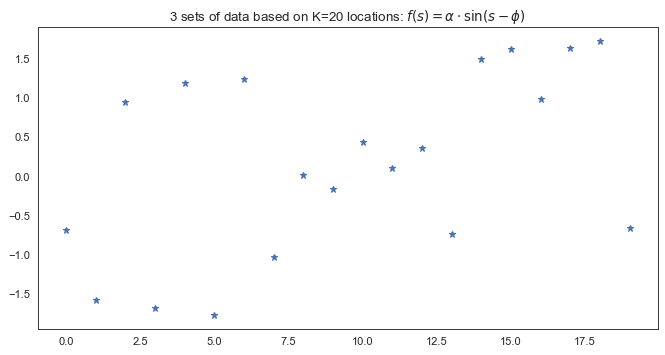

In [71]:
for i in range(1):
    plt.plot(dataset_sine_x[i,0,:], '*')
plt.title("3 sets of data based on K=20 locations: " r'$f(s)=\alpha \cdot \sin(s-\phi)$')
plt.show()

In [72]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()                                  
    
        self.phi_rbf_centers = nn.Parameter(torch.tensor(
            np.random.uniform(s_lims[0], s_lims[1],
            size=(num_phi_rbf, input_dim))))
        self.phi_nn_1 = nn.Linear(num_phi_rbf, phi_hidden_layer_size)
        self.phi_nn_2 = nn.Linear(phi_hidden_layer_size, beta_dim)

        self.encoder_nn_1 = nn.Linear(beta_dim, z_dim * 2)
        #self.encoder_nn_2 = nn.Linear(encoder_h_dim_1, encoder_h_dim_2)
        #self.encoder_nn_3 = nn.Linear(encoder_h_dim_2, encoder_h_dim_3)
        #self.encoder_nn_4 = nn.Linear(encoder_h_dim_3, z_dim * 2)

        self.decoder_nn_1 = nn.Linear(z_dim, beta_dim)
        #self.decoder_nn_2 = nn.Linear(decoder_h_dim_1, decoder_h_dim_2)
        #self.decoder_nn_3 = nn.Linear(decoder_h_dim_2, decoder_h_dim_3)
        #self.decoder_nn_4 = nn.Linear(decoder_h_dim_3, beta_dim)

        # self.betas = nn.Parameter(torch.ones(num_training_funcs, beta_dim))
        self.betas = nn.Parameter(torch.tensor(
            np.random.uniform(-1, 1, size=(num_training_funcs, beta_dim))
        ))

        self.normal_sampler = torch.distributions.normal.Normal(0.0, 1.0)


    def Phi(self, input):
        #print('input size')
        #print(input.shape)
        
        input_expand = torch.unsqueeze(input, 1)
        #print('input_expand size')
        #print(input_expand.shape)
        
        #print('self.phi_rbf_centers size')
        #print(self.phi_rbf_centers.shape)
        
        phi_expand = torch.unsqueeze(self.phi_rbf_centers, 0)
        #print('phi_expand size')
        #print(phi_expand.shape)
        M1 = input_expand - phi_expand
        M2 = torch.sum(M1 ** 2, 2)

        M3 = torch.exp(-M2/phi_rbf_sigma)
        M4 = F.sigmoid(self.phi_nn_1(M3))
        M5 = self.phi_nn_2(M4)
        return M5
     

    def encoder(self, input):
        
        # input (batch x beta_dim) output ((batch x z_dim), (batch x z_dim))
        M1 = self.encoder_nn_1(input)
        #M2 = F.relu(self.encoder_nn_2(M1))
        #M3 = F.relu(self.encoder_nn_3(M2))
        #M4 = self.encoder_nn_4(M3)
        z_mean = M1[:, 0:z_dim]
        z_std = torch.exp(M1[:, z_dim:]) # needs to be positive
        return z_mean, z_std

    def decoder(self, input):
        # input (batch x z_dim) output (batch x beta_dim)
        M1 = self.decoder_nn_1(input)
        #M2 = F.relu(self.decoder_nn_2(M1))
        #M3 = F.relu(self.decoder_nn_3(M2))
        #M4 = self.decoder_nn_4(M3)
        return M1
    
    
    

    def get_loss_term_1(self, fct_id, s, x):
        batch_size = s.shape[0]
        phi_s = self.Phi(s)        
        original_beta_fct_id = self.betas[fct_id, :]        
        x_enc = torch.matmul(phi_s, original_beta_fct_id)                
        loss_term_1 = (x - x_enc)**2
        
        return torch.mean(loss_term_1)

       
    def get_loss_term_2(self, fct_id, s, x): 
        phi_s = self.Phi(s)    
        original_beta_fct_id = self.betas[fct_id, :]        
        z_mean, z_std = self.encoder(original_beta_fct_id.unsqueeze(0))       
        z_sample = z_mean.double() + z_std.double() * self.normal_sampler.rsample((1, z_dim)).double()                    
        beta_hat = self.decoder(z_sample)        
        x_dec = torch.matmul(phi_s, beta_hat.squeeze())         
        loss_term_2 = (x - x_dec)**2
        
        return torch.mean(loss_term_2)

    
    def get_loss_term_3(self, fct_id, kl_factor):        
        original_beta_fct_id = self.betas[fct_id, :]  
        z_mean, z_std = self.encoder(original_beta_fct_id.unsqueeze(0))    
        loss_term_3 = 0.5 * torch.sum(z_std**2 + z_mean**2 - 1 - torch.log(z_std**2),dim=1)       
        loss_term_3 = kl_factor * (loss_term_3/z_dim)
        return loss_term_3       
        

   
    def get_loss(self, function_id, s, x, kl_factor, print_breakdown=False, 
        return_breakdown=False):
        batch_size = s.shape[0]

        phi_s = self.Phi(s)
        beta = self.betas[function_id, :]
        x_enc = torch.matmul(phi_s, beta)

        loss_term_1 = (x - x_enc)**2

        z_mean, z_std = self.encoder(beta.unsqueeze(0))
        z_sample = z_mean + z_std * self.normal_sampler.rsample((1, z_dim))
        beta_hat = self.decoder(z_sample)
        x_dec = torch.matmul(phi_s, beta_hat.squeeze()) 
        loss_term_2 = (x - x_dec)**2

     
        loss_term_3 = 0.5 * torch.sum(z_std**2 + z_mean**2 - 1 - torch.log(z_std**2),
            dim=1)
        loss_term_3 = kl_factor * (loss_term_3/z_dim)

        if print_breakdown:
            print("1", torch.mean(loss_term_1))
            print("2", torch.mean(loss_term_2))
            print("3", loss_term_3)

        if return_breakdown == False:
            return torch.mean(loss_term_1 + loss_term_2) + loss_term_3
        else:
            return torch.mean(loss_term_1 + loss_term_2) + loss_term_3, \
                torch.mean(loss_term_1), torch.mean(loss_term_2), loss_term_3

    
    # Compute decoded x values at location points s
    # when the value of the latent variable z is given by the posterior
    def evaluate_decoded_x_at_given_z(self, z, s, return_beta_hat=False):        
        phi_s = self.Phi(s)       
        beta_hat = self.decoder(z)        
        x_dec = torch.matmul(phi_s, beta_hat)        
        if not return_beta_hat:
            return x_dec
        else:
            return x_dec, beta_hat
   

    # Generate samples from the pivae, with z ~ N(0,1)
    def generate_x_samples_from_pivae(self, s, num_samples):               
        z_samples = self.normal_sampler.rsample((num_samples, z_dim)).double()        
        beta_hats = self.decoder(z_samples)
        phi_s = self.Phi(s)
        x_dec = torch.matmul(beta_hats.unsqueeze(1).unsqueeze(1),
            phi_s.unsqueeze(2).unsqueeze(0))
        x_dec = x_dec.squeeze()

        return x_dec

In [73]:
pivae_model=Model().double()
pivae_model

Model(
  (phi_nn_1): Linear(in_features=100, out_features=20, bias=True)
  (phi_nn_2): Linear(in_features=20, out_features=100, bias=True)
  (encoder_nn_1): Linear(in_features=100, out_features=40, bias=True)
  (decoder_nn_1): Linear(in_features=20, out_features=100, bias=True)
)

In [74]:
#KL divergence factor: 
kl_factor=1.0

#learning rate
learning_rate=0.001

#this is the number of input functions used in training
num_funcs_to_consider = 50
current_max = 1000
interval = 3

total_nbr_epochs=300

In [75]:
optimizer=torch.optim.Adam(pivae_model.parameters(), lr=learning_rate)

In [76]:
Loss_per_epoch_append = []
L1_per_epoch_append = []
L2_per_epoch_append = []
L3_per_epoch_append = []

In [77]:
for epoch_id in range(total_nbr_epochs):
    
    print("epoch id:", epoch_id)
    l1s = []
    l2s = []
    l3s = []
    losses=[]
    

    
    for function_id in range(num_funcs_to_consider):
        optimizer.zero_grad()
        input_points = torch.tensor(dataset_sine_s[function_id])
        x_vals = torch.tensor(dataset_sine_x[function_id])
        loss, l1, l2, l3 = pivae_model.get_loss(function_id, input_points, x_vals,
            kl_factor, return_breakdown=True)
        loss.backward()
        optimizer.step()
        l1s.append(l1.detach().cpu().numpy())
        l2s.append(l2.detach().cpu().numpy())
        l3s.append(l3.detach().cpu().numpy())
        losses.append(loss.detach().cpu().numpy())

    if epoch_id % interval == 0:
        num_funcs_to_consider = min(num_funcs_to_consider+1, current_max)
        
    L1=np.mean(np.array(l1s))
    L2= np.mean(np.array(l2s))
    L3=np.mean(np.array(l3s))
    Loss=np.mean(np.array(losses))
       

    print("L1", L1,
        "L2", L2,
        "L3", L3,
        "Loss", Loss,
        "num funcs", num_funcs_to_consider)
    
    Loss_per_epoch_append.append(Loss)
    L1_per_epoch_append.append(L1)
    L2_per_epoch_append.append(L2)
    L3_per_epoch_append.append(L3)

print("Loss_per_epoch_append:")
print(Loss_per_epoch_append)

print("L1_per_epoch_append")
print(L1_per_epoch_append)

print("L2_per_epoch_append")
print(L2_per_epoch_append)

print("L3_per_epoch_append")
print(L3_per_epoch_append)


    

epoch id: 0
L1 7.119766241402536 L2 6.033942340459212 L3 0.19003988015540849 Loss 13.343748462017158 num funcs 51
epoch id: 1
L1 5.271918263734831 L2 4.532966677444627 L3 0.18025444171506325 Loss 9.985139382894522 num funcs 51
epoch id: 2
L1 4.621185961257018 L2 4.305810192720128 L3 0.16840196438414193 Loss 9.095398118361286 num funcs 51
epoch id: 3
L1 4.294589086183502 L2 4.422640359365532 L3 0.15756091466162422 Loss 8.874790360210659 num funcs 52
epoch id: 4
L1 4.123455396478787 L2 4.301520534432175 L3 0.147651030015887 Loss 8.57262696092685 num funcs 52
epoch id: 5
L1 4.014143487123268 L2 4.360328933759271 L3 0.13906946497632192 Loss 8.513541885858862 num funcs 52
epoch id: 6
L1 3.942799993798162 L2 4.340177779646216 L3 0.13144410725887964 Loss 8.414421880703259 num funcs 53
epoch id: 7
L1 3.8458656063410923 L2 4.305963606755006 L3 0.12455771763765629 Loss 8.276386930733754 num funcs 53
epoch id: 8
L1 3.806364073006167 L2 4.22684612431147 L3 0.11806997693846126 Loss 8.15128017425609

L1 2.6273246886628314 L2 3.0546216346963884 L3 0.4773496864556331 Loss 6.159296009814852 num funcs 75
epoch id: 73
L1 2.6738860260918718 L2 3.015662951254575 L3 0.4804487266607153 Loss 6.169997704007161 num funcs 75
epoch id: 74
L1 2.646935158748125 L2 2.9795722502570916 L3 0.4853118644800777 Loss 6.1118192734852945 num funcs 75
epoch id: 75
L1 2.612517470054875 L2 3.025591894756726 L3 0.4923643802440023 Loss 6.130473745055602 num funcs 76
epoch id: 76
L1 2.6363262107410215 L2 3.00818546192676 L3 0.5012965640117093 Loss 6.14580823667949 num funcs 76
epoch id: 77
L1 2.582833319347245 L2 2.8836043523495447 L3 0.5051635855571464 Loss 5.971601257253936 num funcs 76
epoch id: 78
L1 2.542920848272949 L2 2.8679496025771116 L3 0.5074910591645898 Loss 5.918361510014651 num funcs 77
epoch id: 79
L1 2.6424097567038327 L2 3.0550415728452798 L3 0.5114588349047697 Loss 6.208910164453881 num funcs 77
epoch id: 80
L1 2.596405794751677 L2 2.9670461157898873 L3 0.5226008381271267 Loss 6.086052748668691 

L1 0.6838483681515748 L2 0.5590075516093385 L3 0.41917649491161457 Loss 1.6620324146725278 num funcs 99
epoch id: 145
L1 0.7080329902530186 L2 0.5399819591871878 L3 0.41512587735885664 Loss 1.663140826799063 num funcs 99
epoch id: 146
L1 0.664961157899664 L2 0.4466454984719458 L3 0.4165461107132954 Loss 1.5281527670849056 num funcs 99
epoch id: 147
L1 0.6169893842289991 L2 0.45126468188812324 L3 0.4093698647537488 Loss 1.4776239308708707 num funcs 100
epoch id: 148
L1 0.6179600469488523 L2 0.5663070967290039 L3 0.4050783354217439 Loss 1.5893454790996 num funcs 100
epoch id: 149
L1 0.6300611795777891 L2 0.6074340482579877 L3 0.3992597842253815 Loss 1.636755012061158 num funcs 100
epoch id: 150
L1 0.5609049080531782 L2 0.5249140969949564 L3 0.4046623730968135 Loss 1.4904813781449477 num funcs 101
epoch id: 151
L1 0.5690659525862503 L2 0.42354168816644694 L3 0.3967570487354456 Loss 1.3893646894881426 num funcs 101
epoch id: 152
L1 0.5134544780868283 L2 0.48030944698920114 L3 0.39561727092

L1 0.28826704978173734 L2 0.28215585559310796 L3 0.24925378627645375 Loss 0.8196766916512991 num funcs 122
epoch id: 215
L1 0.2706603614959073 L2 0.26974484708131863 L3 0.25027879974654677 Loss 0.7906840083237726 num funcs 122
epoch id: 216
L1 0.24434240825992773 L2 0.26614236893935944 L3 0.2572484531516637 Loss 0.767733230350951 num funcs 123
epoch id: 217
L1 0.2935867303305854 L2 0.2621065829474678 L3 0.2548510762076974 Loss 0.8105443894857506 num funcs 123
epoch id: 218
L1 0.2729045281868164 L2 0.29488870504012865 L3 0.25194924878640695 Loss 0.8197424820133519 num funcs 123
epoch id: 219
L1 0.25080436415080426 L2 0.23687548199660222 L3 0.25325919084871434 Loss 0.7409390369961208 num funcs 124
epoch id: 220
L1 0.33792681288888876 L2 0.32344539542461026 L3 0.25010219501575176 Loss 0.9114744033292509 num funcs 124
epoch id: 221
L1 0.32855811909130833 L2 0.27786862340898705 L3 0.25079791591651807 Loss 0.8572246584168135 num funcs 124
epoch id: 222
L1 0.31139188171651794 L2 0.29116247546

L1 0.12321655667057295 L2 0.18152477416683693 L3 0.2438132666272075 Loss 0.5485545974646173 num funcs 145
epoch id: 284
L1 0.10972392281095532 L2 0.19087998637948878 L3 0.24684422454798532 Loss 0.5474481337384294 num funcs 145
epoch id: 285
L1 0.09668850903463294 L2 0.17686594807899583 L3 0.24770282314671271 Loss 0.5212572802603415 num funcs 146
epoch id: 286
L1 0.1606988737537285 L2 0.2322357355749266 L3 0.24538536852573198 Loss 0.638319977854387 num funcs 146
epoch id: 287
L1 0.15802634976378188 L2 0.23592523696467785 L3 0.24675166431186027 Loss 0.64070325104032 num funcs 146
epoch id: 288
L1 0.12214459852635662 L2 0.232291983074211 L3 0.25079645277433016 Loss 0.6052330343748978 num funcs 147
epoch id: 289
L1 0.13022674662112382 L2 0.18521105436278051 L3 0.2526062304645381 Loss 0.5680440314484425 num funcs 147
epoch id: 290
L1 0.11433894313016825 L2 0.18551424104805328 L3 0.24817056533347895 Loss 0.5480237495117006 num funcs 147
epoch id: 291
L1 0.09989015985344303 L2 0.1694387173777

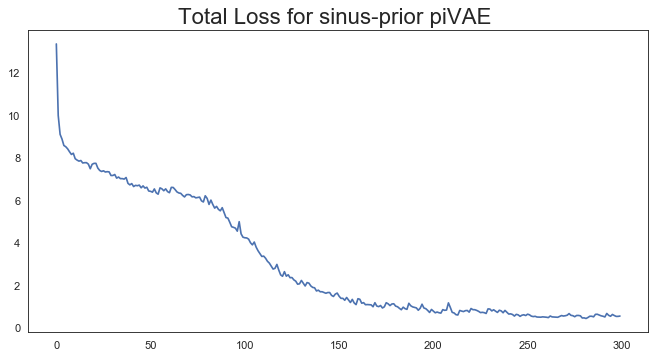

In [78]:
plt.plot(Loss_per_epoch_append)
plt.title("Total Loss for sinus-prior piVAE ", fontsize=20 )
plt.show()

Text(0.5, -0.2, '$L_1=\\frac{1}{\\sigma^2_0}[x-\\beta^T\\cdot\\Phi(s)]^2}$')

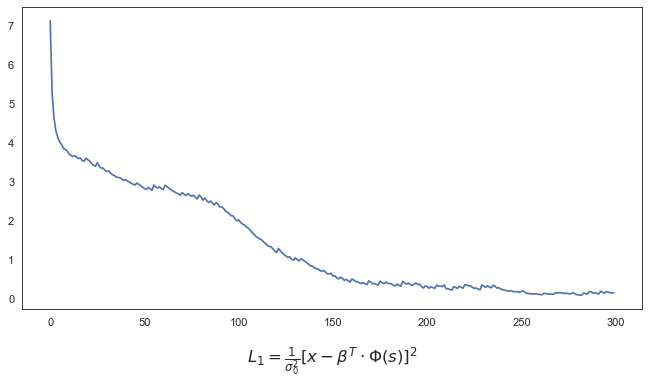

In [79]:
plt.plot(L1_per_epoch_append)
plt.title(r'$L_1=\frac{1}{\sigma^2_0}[x-\beta^T\cdot\Phi(s)]^2}$',fontsize=15, y=-0.2)

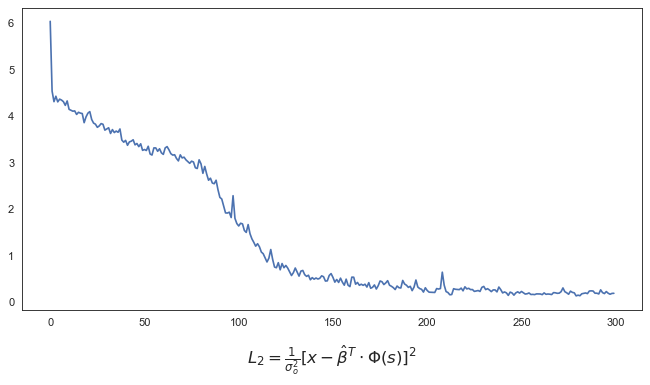

In [80]:
plt.plot(L2_per_epoch_append)
plt.title(r'$L_2=\frac{1}{\sigma^2_o}[x-\hat\beta^T\cdot\Phi(s)]^2}$',fontsize=15, y=-0.2)
plt.show()

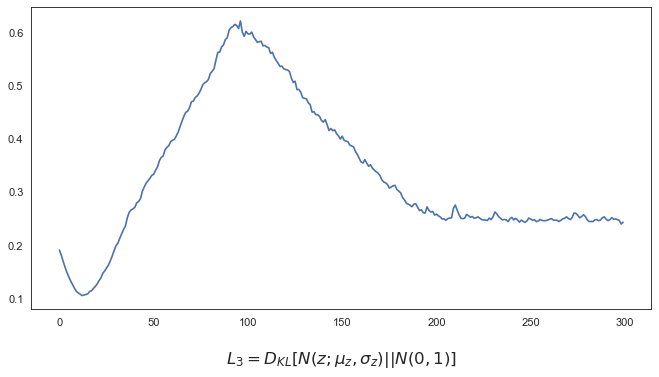

In [81]:
plt.plot(L3_per_epoch_append)
plt.title(r'$L_3=D_{KL}[N(z; \mu_z, \sigma_z)||N(0,1)]$', fontsize=15, y=-0.2)
plt.show()

### Generate Sine samples from piVAE using $z \sim N(0,1):$

In [82]:
num_piVAE_samples=3

In [83]:
test_pts_for_plot_tensor = torch.arange(-5., 5., 0.05).double() 
test_pts_for_plot_tensor.shape    

torch.Size([200])

In [84]:
test_pts_for_plot_np = np.arange(-5., 5., 0.05)
test_pts_for_plot_np.shape    

(200,)

In [85]:
piVAE_samples_tensor = pivae_model.generate_x_samples_from_pivae(
                                test_pts_for_plot_tensor.unsqueeze(1),5)

In [86]:
piVAE_samples_np = np.array(piVAE_samples_tensor.detach().numpy())

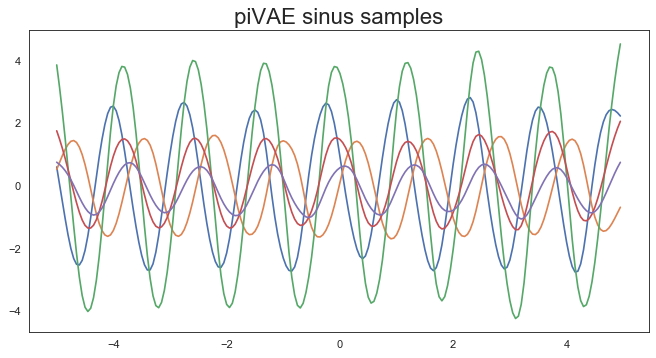

In [87]:
for i in range(piVAE_samples_np.shape[0]):
    plt.plot(test_pts_for_plot_tensor.detach().cpu().numpy(), piVAE_samples_np[i, :])
plt.title("piVAE sinus samples", fontsize=20)
plt.show()

In [88]:
def plot_decoded_x_samples_from_z_posterior(model, z_samples_from_post, s_star_tensor, x_star_tensor):    
            
    for i in range(z_samples_from_post.shape[0]):
        # Evaluates decoded x at location test_points when the value of the latent z_samples are given
        decoded_x = model.evaluate_decoded_Sine_at_given_z(z_samples_from_post[i,:],
                                                           test_pts_for_plot_tensor.unsqueeze(1))

        plt.plot(test_pts_for_plot_np, decoded_x.detach().numpy(), alpha=0.1, color='black')

    
    plt.scatter(s_star_tensor.detach().numpy(), x_star_tensor.detach().numpy(), s=1000, marker="+")
    plt.show()

In [89]:
# Compute a quantity proportional to p(z|x, s) where x and s are new test points
def get_unnormalized_log_posterior(model, s, x, z, obs_sigma):        
        
    #z ~ N(0,1)
    log_prior = -0.5 * torch.sum(z**2)

    phi_s = model.Phi(s)

    beta_hat = model.decoder(z)
    
    x_dec = torch.matmul(phi_s, beta_hat.squeeze()) 
    
    x=torch.squeeze(x)
    
    #GAUSSIAN LL 
    log_likelihoods = (-1 / (2 * obs_sigma**2)) * (x_dec - x)**2

    return log_prior + torch.sum(log_likelihoods)

In [90]:
def draw_MCMC_z_samples(model, nbr_z_samples, z_starting_point, MH_proposal_sigma, obs_sigma, s_star_tensor, x_star_tensor):
        
    z = z_starting_point
    #create a tensor of zeros to contain the z values that are going to be sampled
    z_samples = torch.zeros((nbr_z_samples, z_dim)).double()

    acceptance_prob_sum = 0

    for z_sample in range(nbr_z_samples):
        if(z_sample %1000==0):
            print("sample_id",z_sample)
              
        #z_p ~ N(z,MH_sigma**2)
        z_proposed = z + torch.randn_like(z) * MH_proposal_sigma**2            

        log_posterior_z = get_unnormalized_log_posterior(model, s_star_tensor, 
                                                         x_star_tensor, z, obs_sigma)

        log_posterior_z_proposed = get_unnormalized_log_posterior(model, s_star_tensor, 
                                                                x_star_tensor, z_proposed, obs_sigma)

        MH_ratio = torch.exp(log_posterior_z_proposed - log_posterior_z)

        acceptance_prob = torch.min(torch.tensor(1.0).double(), MH_ratio)

        u = torch.rand(1).double()

        if u < acceptance_prob:
            z = z_proposed

        z_samples[z_sample, :] = z

        acceptance_prob_sum += acceptance_prob.detach()

    print("mean acceptance prob", acceptance_prob_sum/nbr_z_samples)
    return z_samples


In [91]:
#amplitude = np.random.uniform(1.0, 5.0)
#phase = np.random.uniform(0, 2 * np.pi)      
#sin_s = amplitude * np.sin(s*5 - phase)

amplitude_grd_truth=2.0
phase_grd_truth=np.pi

def ground_truth_sinus_fct(locations):
    return amplitude_grd_truth * np.sin(5.0*locations - phase_grd_truth)

In [92]:
s_star_np=np.arange(-5.,5,0.1)
s_star_np.shape

(100,)

In [93]:
x_star_np=ground_truth_sinus_fct(s_star_np)
x_star_np.shape

(100,)

In [94]:
#create a data frame with 2 columns: one for the s_star and one for the x_star
df=pd.DataFrame(s_star_np)
df['x_star']=x_star_np
df['s_star']=s_star_np
#df

In [95]:
#select observations from ground truth
nbr_obs=10
s_obs=np.zeros(nbr_obs)
x_obs=np.zeros(nbr_obs)

k=int(len(s_star_np)/nbr_obs)
print(k)
for i in range(nbr_obs):
    s_obs[i]=df['s_star'][k*i]
    x_obs[i]=df['x_star'][k*i]
s_obs.shape

10


(10,)

In [96]:
#add noise to ground truth
sigma_noise=0.1
epsilon = np.random.normal(loc=0, scale=sigma_noise, size=len(x_obs))
epsilon.shape
y_obs=np.zeros(nbr_obs)
y_obs.shape
y_obs=x_obs +epsilon
y_obs.shape

(10,)

nbr observations: 10


Text(0.5, 1.0, 'Ground truth OU prior and 10 observations')

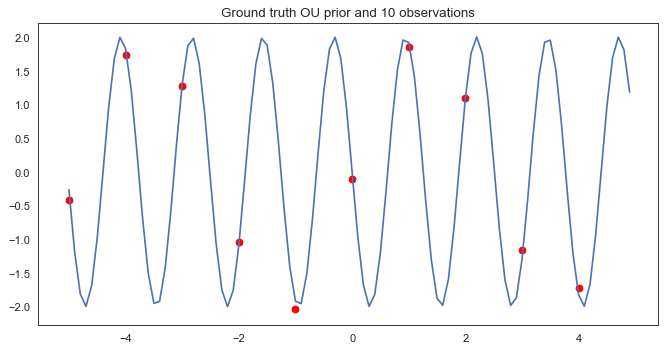

In [97]:
plt.plot(s_star_np, x_star_np, label='Ground truth')
plt.scatter(s_obs, y_obs, color='r')
print("nbr observations:", len(y_obs))
length=len(y_obs)
plt.title('Ground truth OU prior and 10 observations')
#plt.show()

In [98]:
z = torch.ones((z_dim,)).double()

#when MH_proposal_sigma increases the credible interval gets too narrow 
#when obs_sigma decreases: the mean posterior gets closer to the ground truth

nbr_iter=10000
MH_proposal_sigma=1.
obs_sigma=1.5

mcmc_samples = draw_MCMC_z_samples(pivae_model, nbr_iter, z, MH_proposal_sigma, obs_sigma, torch.tensor(s_obs).unsqueeze(1), 
                                        torch.tensor(y_obs))

sample_id 0
sample_id 1000
sample_id 2000
sample_id 3000
sample_id 4000
sample_id 5000
sample_id 6000
sample_id 7000
sample_id 8000
sample_id 9000
mean acceptance prob tensor(0.0160, dtype=torch.float64)


In [99]:
mcmc_selected_samples_run1 = mcmc_samples[1000::100,:]

In [100]:
mcmc_selected_samples_run1.shape

torch.Size([90, 20])

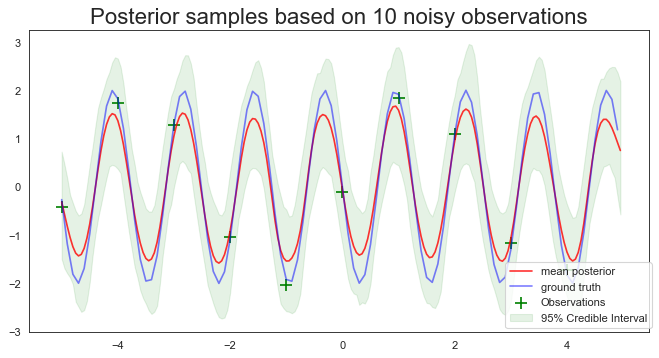

In [101]:
all_dec_x=[]    
for i in range(len(mcmc_selected_samples_run1)):
        
    decoded_x = pivae_model.evaluate_decoded_x_at_given_z(mcmc_selected_samples_run1[i,:], 
                                                             test_pts_for_plot_tensor.unsqueeze(1))
    
    #plt.plot(test_pts_for_plot_np, decoded_x.detach().numpy(), alpha=0.1, color='grey')
    
    all_dec_x.append(decoded_x.detach().numpy())  
      
mean_dec_x=np.mean(np.array(all_dec_x), axis=0)

quantile_0975_dec_x=np.quantile(np.array(all_dec_x),0.975,axis=0)

quantile_0025_dec_x=np.quantile(np.array(all_dec_x),0.025,axis=0)
    
plt.plot(test_pts_for_plot_np, mean_dec_x, alpha=0.8, color='r', label='mean posterior')
    
plt.scatter(s_obs, y_obs, color="g", s=100, marker="+", label="Observations")
plt.plot(s_star_np, x_star_np, alpha=0.5, color='b', label="ground truth")

plt.fill_between(test_pts_for_plot_np, quantile_0025_dec_x, quantile_0975_dec_x,
                    facecolor="green",
                    color='green', 
                    alpha=0.1, label = '95% Credible Interval') 

plt.legend(bbox_to_anchor=(0.76, 0.25))
plt.title("Posterior samples based on 10 noisy observations", fontsize=20)
plt.show()

In [102]:
all_dec_x_10=[]    
for i in range(len(mcmc_selected_samples_run1)):
    decoded_new_x_10 = eval_decoded_x_at_given_z(pivae_model, mcmc_selected_samples_run1[i,:], 
                                                             torch.tensor(s_obs).unsqueeze(1))

    all_dec_x_10.append(decoded_new_x_10.detach().numpy())  
      
new_star_mean_post_10=np.mean(np.array(all_dec_x_10), axis=0)
new_star_mean_post_10.shape

nbr_new_star_10=10
RMSE_10_obs=np.sqrt(np.sum((new_star_mean_post_10 - x_obs)**2/nbr_new_star_10))
RMSE_10_obs

0.2918751857347985

In [103]:
#select 20 new points from the dataframe
nbr_new_star=5
s_obs_20=np.zeros(nbr_new_star)
x_obs_20=np.zeros(nbr_new_star)
for i in range(nbr_new_star):
    s_obs_20[i]=df['s_star'][15*i+3]
    x_obs_20[i]=df['x_star'][15*i+3]
x_obs_20.shape

(5,)

Text(0.5, 1.0, 'Ground truth OU prior')

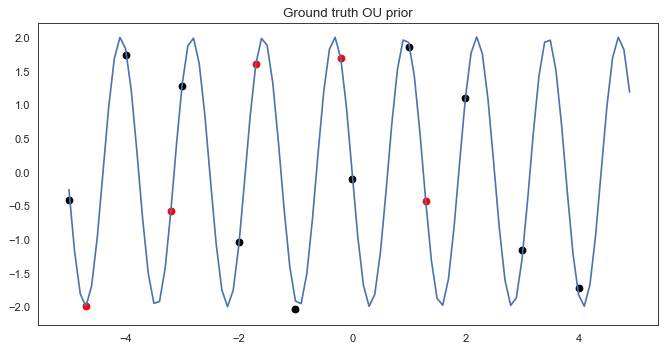

In [104]:
plt.plot(s_star_np, x_star_np, label='Ground truth')
plt.scatter(s_obs, y_obs, color='k')
plt.scatter(s_obs_20, x_obs_20,color="r")
#plt.scatter(s_star_np, y_obs, color='r', label='Noisy Observations')

#plt.legend(loc='upper left', borderaxespad=0.)
plt.title('Ground truth OU prior')
#plt.show()

In [105]:
#now we need to compute the posterior at these 20 new points
#the way to do this is to run MCMC on these samples and take the mean posterior of these samples
nbr_iter_2=10000
z = torch.ones((z_dim,)).double()

mcmc_samples2 = draw_MCMC_z_samples(pivae_model, nbr_iter_2, z, MH_proposal_sigma, obs_sigma, 
                                   torch.tensor(s_obs_20).unsqueeze(1), torch.tensor(x_obs_20))

sample_id 0
sample_id 1000
sample_id 2000
sample_id 3000
sample_id 4000
sample_id 5000
sample_id 6000
sample_id 7000
sample_id 8000
sample_id 9000
mean acceptance prob tensor(0.0264, dtype=torch.float64)


In [106]:
mcmc_selected_samples_run2 = mcmc_samples2[1000::100,:]

In [107]:
mcmc_selected_samples_run2.shape

torch.Size([90, 20])

In [108]:
def eval_decoded_x_at_given_z(model, z, s):        
        phi_s = model.Phi(s)       
        beta_hat = model.decoder(z)        
        x_dec = torch.matmul(phi_s, beta_hat)        
        return x_dec   

In [109]:
all_dec_x=[]    
for i in range(len(mcmc_selected_samples_run2)):
    decoded_new_x = eval_decoded_x_at_given_z(pivae_model, mcmc_selected_samples_run2[i,:], 
                                                             torch.tensor(s_obs_20).unsqueeze(1))

    all_dec_x.append(decoded_new_x.detach().numpy())  
      
new_star_mean_post=np.mean(np.array(all_dec_x), axis=0)
new_star_mean_post.shape

#nbr_new_star=5
RMSE=np.sqrt(np.sum((new_star_mean_post - x_obs_20)**2/nbr_new_star))
RMSE

0.40473446858713513

In [110]:
#nbr_new_star=5
RMSE=np.sqrt(np.sum((new_star_mean_post - x_obs_20)**2/nbr_new_star))
RMSE

0.40473446858713513

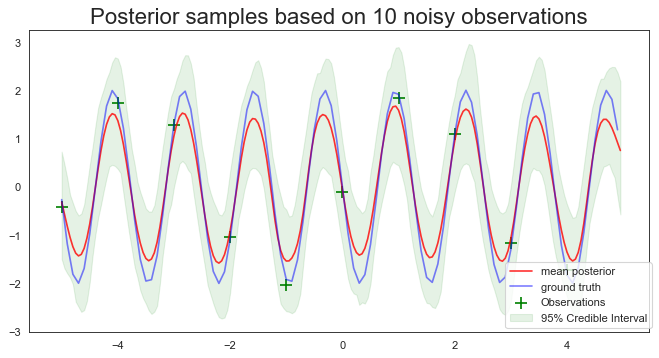

In [111]:
all_dec_x=[]    
for i in range(len(mcmc_selected_samples_run1)):
        
    decoded_x = pivae_model.evaluate_decoded_x_at_given_z(mcmc_selected_samples_run1[i,:], 
                                                             test_pts_for_plot_tensor.unsqueeze(1))
    
    #plt.plot(test_pts_for_plot_np, decoded_x.detach().numpy(), alpha=0.1, color='grey')
    
    all_dec_x.append(decoded_x.detach().numpy())  
      
mean_dec_x=np.mean(np.array(all_dec_x), axis=0)

quantile_0975_dec_x=np.quantile(np.array(all_dec_x),0.975,axis=0)

quantile_0025_dec_x=np.quantile(np.array(all_dec_x),0.025,axis=0)
    
plt.plot(test_pts_for_plot_np, mean_dec_x, alpha=0.8, color='r', label='mean posterior')
    
plt.scatter(s_obs, y_obs, color="g", s=100, marker="+", label="Observations")
plt.plot(s_star_np, x_star_np, alpha=0.5, color='b', label="ground truth")

plt.fill_between(test_pts_for_plot_np, quantile_0025_dec_x, quantile_0975_dec_x,
                    facecolor="green",
                    color='green', 
                    alpha=0.1, label = '95% Credible Interval') 

plt.legend(bbox_to_anchor=(0.76, 0.25))
plt.title("Posterior samples based on 10 noisy observations", fontsize=20)
plt.show()

In [ ]:
nbr_star_pts=100
s_star_np=np.linspace(-4.9,4.9,nbr_star_pts)
s_star_np.shape

In [ ]:
x_star_np=ground_truth_sinus_fct(s_star_np)
x_star_np.shape

In [ ]:
#add noise to ground truth
sigma_noise=0.4
epsilon = np.random.normal(loc=0, scale=sigma_noise, size=len(x_star_np))
epsilon.shape
y_obs=np.zeros(len(x_star_np))
y_obs.shape
y_obs=x_star_np +epsilon

y_obs.shape

In [ ]:
plt.plot(test_pts_for_plot_np, ground_truth_sinus_fct(test_pts_for_plot_np), label='Ground truth')
plt.scatter(s_star_np, y_obs, color='r', label='Noisy Observations')

plt.legend(loc='upper left', borderaxespad=0.)

plt.show()

In [ ]:
z = torch.ones((z_dim,)).double()

In [ ]:
#self, nbr_z_samples, z_starting_point, MH_proposal_sigma, obs_sigma, s_star_tensor, x_star_tensor)
nbr_iter=10000
MH_proposal_sigma=0.05
obs_sigma=0.01

mcmc_samples = draw_MCMC_z_samples(pivae_model, nbr_iter, z, MH_proposal_sigma, obs_sigma, torch.tensor(s_star_np).unsqueeze(1), 
                                        torch.tensor(y_obs))

In [ ]:
mcmc_selected_samples_run1 = mcmc_samples[1000::500,:]

In [ ]:
mcmc_selected_samples_run1.shape

In [ ]:
all_dec_x=[]    
for i in range(len(mcmc_selected_samples_run1)):
        
    decoded_x = pivae_model.evaluate_decoded_Sine_at_given_z(mcmc_selected_samples_run1[i,:], 
                                                             test_pts_for_plot_tensor.unsqueeze(1))
    
    plt.plot(test_pts_for_plot_np, decoded_x.detach().numpy(), alpha=0.1, color='grey')
    
    all_dec_x.append(decoded_x.detach().numpy())  
      
mean_dec_x=np.mean(np.array(all_dec_x), axis=0)

quantile_0975_dec_x=np.quantile(np.array(all_dec_x),0.001,axis=0)

quantile_0025_dec_x=np.quantile(np.array(all_dec_x),0.999,axis=0)
    
plt.plot(test_pts_for_plot_np, mean_dec_x, alpha=0.2, color='blue', label='mean posterior')
    
plt.scatter(s_star_np, x_star_np, color="red", s=100, marker="+", label="Observations")

plt.fill_between(test_pts_for_plot_np, quantile_0025_dec_x, quantile_0975_dec_x,
                    facecolor="green",
                    color='green', 
                    alpha=0.1, label = '95% Credible Interval') 

plt.legend(loc="lower right")
plt.title("Posterior samples for PiVAE on sinus functions")
plt.show()

In [ ]:
#from the same function that generated 4 observation points, get new points 
#see the value of both Pi-VAE and Gp posterior. 
#Compute them against known function and report the RMSE. 

In [ ]:
#get 2 new points from the ground truth function:
nbr_new_star_pts=20
s_star_new_np=np.linspace(-4.,4., nbr_new_star_pts)
s_star_new_np

In [ ]:
x_star_new_np=ground_truth_sinus_fct(s_star_new_np)
x_star_new_np

In [ ]:
#now we need to compute the posterior at these 20 new points
#the way to do this is to run MCMC on these samples and take the mean posterior of these samples

mcmc_samples2 = draw_MCMC_z_samples(pivae_model, nbr_iter, z, MH_proposal_sigma, obs_sigma, 
                                   torch.tensor(s_star_new_np).unsqueeze(1), torch.tensor(x_star_new_np))

In [ ]:
mcmc_selected_samples_run2 = mcmc_samples2[1000::500,:]

In [ ]:
mcmc_selected_samples_run2.shape

In [ ]:
def eval_decoded_x_at_given_z(model, z, s):        
        phi_s = model.Phi(s)       
        beta_hat = model.decoder(z)        
        x_dec = torch.matmul(phi_s, beta_hat)        
        return x_dec   

In [ ]:
all_dec_x=[]    
for i in range(len(mcmc_selected_samples_run2)):
    decoded_new_x = eval_decoded_x_at_given_z(pivae_model, mcmc_selected_samples_run2[i,:], 
                                                             torch.tensor(s_star_new_np).unsqueeze(1))

    all_dec_x.append(decoded_new_x.detach().numpy())  
      
new_star_mean_post=np.mean(np.array(all_dec_x), axis=0)
new_star_mean_post.shape

In [ ]:
RMSE=np.sqrt(np.sum((new_star_mean_post-x_star_new_np)**2/nbr_new_star_pts))
RMSE

In [ ]:
def check_beta(model, id):
    
    test_points = torch.arange(-5, 5, 0.1).reshape(100, 1)
    
    phi_s = model.Phi(test_points)
    
    beta = model.betas[id, :]
    
    x_encs = torch.matmul(phi_s, beta)
    
    z_mean, z_std = model.encoder(beta.unsqueeze(0))
    
    beta_hat = model.decoder(z_mean)
    
    x_decs = torch.matmul(beta_hat, torch.transpose(phi_s, 0, 1))
    
    #plot encoded x's against test locations
    plt.plot(test_points.detach().cpu().numpy(), x_encs.detach().cpu().numpy(), color='red')
    
    #plot decoded x's against test locations
    plt.plot(test_points.detach().cpu().numpy().reshape(100), x_decs.detach().cpu().numpy().reshape(100), color='green')
    
    plt.scatter(dataset_sine_s[id].reshape(num_eval_points), dataset_sine_x[id].reshape(num_eval_points))
    plt.title("Reconstruction of training data")
    plt.show()

In [ ]:
# ------ Check reconstructions of training data -------
for i in range(2):
    check_beta(pivae_model, i)

#%%